In [1]:
import numpy as np
import pandas as pd
import h5py
import sys
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from statistics import mean
import scipy
from pathlib import Path

from radiometric.LUT import create_LUT_df, determine_reference

from NUC.NUC_functions import import_NUC, apply_NUC, get_slice, determine_slope
from NUC.NUC_functions import determine_dark, apply_DFC_to_df
from NUC.NUC_functions import pixel_registration

In [2]:
#choose filepath to desired data
path = '/Volumes/KESU/jun22/polarized/'
#note cam definitions are flipped as of FLIRPY ffc fix 
cal_file2 =  '/Volumes/KESU/calibration_files/cam1pixel.h5'
cal_file1 =  '/Volumes/KESU/calibration_files/cam2pixel.h5'

In [14]:
waves= np.linspace(7,12,61)
TEMPS = np.linspace(25,80,12)
angles = np.linspace(0,359,360)

In [4]:
#select ROI
ymin2 = 90; ymax2 = 150;
ymin1 = 120; ymax1 = 180;

FOV = 53.51 ;
HFOV = FOV/4;
angles = np.round(np.linspace(-HFOV,HFOV,ymax2-ymin2))

In [5]:
'''LOAD slope from 2 point NUC'''
#choose filepath to desired data
save_path =   '/Volumes/KESU/calibration_files/'
name =  "NUC.h5" 

hf = h5py.File(save_path+name, 'r')
M1 = hf.get('M1')
M2 = hf.get('M2')
T1 = hf.get('Tref1')
T2 = hf.get('Tref2')
ROI1 = hf.get('ROI1')
ROI2 = hf.get('ROI2')

In [7]:
#first, determine reference temp for each camera
ref_name  = '40C.h5'
dark_name = 'dark.h5'

tref1, tref2 = determine_reference(path,ref_name )

'''determine DFC'''
df_dark = create_LUT_df(path,dark_name)
df_ref = create_LUT_df(path,ref_name)
tref1,tref2,D1,D2 = determine_dark(df_dark,df_ref,M1,M2)

Ref T1 is 15.1
Ref T2 is 14.8


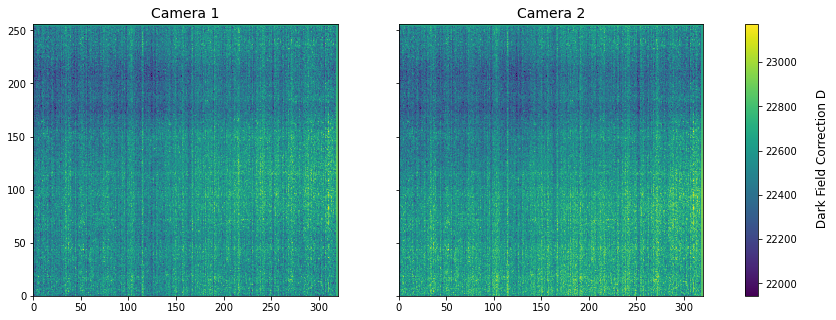

In [9]:
#plot DFCs, check appearance 
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5),sharey = True)
p1 = axes[0].pcolormesh(D1,shading = 'auto')
axes[0].set_title('Camera 1',fontsize = 14)

p2 = axes[1].pcolormesh(D2,shading = 'auto')
axes[1].set_title('Camera 2',fontsize = 14)
cbar = fig.colorbar(p1, ax=axes.ravel().tolist())
cbar.ax.set_ylabel('\n Dark Field Correction D',fontsize = 12)

plt.show()

In [15]:
#apply pixel registration and NUC to full dataset
mean_ims1 =[]
mean_ims2 =[]
std_ims1  =[]
std_ims2  =[]
t1s = []
t2s = []

for i in angles:
    #will create a df and print the names of the keys in the original hdf5 file
    df_i = create_LUT_df(path,str(round(i))+'deg.h5')
    
    #apply 2 point NUC, this df cooresponds to Cij
    df = apply_DFC_to_df(df_i,D1,D2,tref1,tref2,M1,M2)
    
    corrected_images1= [] ; 
    corrected_images2= [] ; 
    
    for i in range(len(df)):
        #load image
        rn = df['imgs1'][i];
        
        #apply pixel registration, this returns C lambda, phi
        T  = df['temps1'][i];
        t1s.append(T)
        cn = pixel_registration(rn,cal_file1,waves,ymin1,ymax1)
        corrected_images1.append(cn)
  

    for i in range(len(df)):
        #load image
        rn = df['imgs2'][i];
        
        #apply pixel registration
        T  = df['temps2'][i];
        t2s.append(T)
        cn = pixel_registration(rn,cal_file2,waves,ymin2,ymax2)
        corrected_images2.append(cn)
        

    mean_ims1.append(np.mean(corrected_images1,axis = 0))
    mean_ims2.append(np.mean(corrected_images2,axis = 0))

    std_ims1.append(np.std(corrected_images1,axis = 0))
    std_ims2.append(np.std(corrected_images2,axis = 0))

In [33]:
mean_ims2


[array([[125.91166666, 184.89066667, 227.20723802, ..., 167.17047618,
         148.48147621,  47.09666675],
        [196.82095243, 223.37571431, 248.49504761, ..., 167.88547618,
         183.78947619, 115.07766666],
        [178.1714286 , 227.04633348, 317.49295256, ...,  71.19795231,
           3.5676663 ,  89.97538074],
        ...,
        [191.05447611, 213.29904761, 178.91795236, ..., 175.26871415,
          54.36542861,  37.09114303],
        [178.63957158, 135.1384287 ,  66.21423808, ...,  48.45761943,
         143.26333334, 162.56561914],
        [ 94.67266669,  69.91195229, 133.9304761 , ..., 101.83052386,
         151.80885711, 205.94314285]]),
 array([[121.88366666, 184.99866667, 227.16123802, ..., 167.60847618,
         146.93947621,  44.68266675],
        [196.98295243, 225.26371431, 248.88704761, ..., 167.74547618,
         186.29147619, 117.52766666],
        [174.9794286 , 225.81233348, 319.11495256, ...,  72.84795231,
           5.9916663 ,  91.21738074],
        ...,
